# 10/15/24: encoding phase plots
* As a reminder, 16 subjs across 29 session undergo watched an ~8 min film.
 
After wrangling all their data into 1 df, I plotted:  
1. Distribution of RTs
2. Rasters & PSTHs for example cells from each region. For the latter, I trimmed all trials to 5s.  
3. Distribution of avg FRs across trials (non-zero FRs only)
4. Trial-avged FR for correct vs incorrect (note that these are imbalanced classes as printed above the plot)
5. Trial-avged FR for (correct+high confidence) vs others (much better balanced)


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os, pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, glob
from pynwb import NWBHDF5IO
from pathlib import Path
from convnwb.io import load_nwbfile

### confirm number of subjects, neurons, trials

In [3]:
df = pd.read_pickle('neuron_by_trial_df.pkl')

df_encoding = df[df['stim_phase'] == 'encoding']
df_baseline = df[df['stim_phase'] == 'baseline']

df_enc_zeroFR = df_encoding[df_encoding['FR'] == 0] # 7 neurons trials get dropped
df_base_zeroFR = df_baseline[df_baseline['FR'] == 0] # 15 neurons trials get dropped

drop_enc_neur = df_enc_zeroFR['neuron'].unique()
drop_base_neur = df_base_zeroFR['neuron'].unique()
drop_zeroFR_neur = np.concatenate((drop_enc_neur, drop_base_neur))

print(f'neuron trials getting dropped due to having FR=0 in either encoding or baseline {drop_zeroFR_neur}')

# from df_encoding and df_baseline, drop the sessions with 0 FR
df_encoding = df_encoding[~df_encoding['neuron'].isin(drop_zeroFR_neur)]
df_baseline = df_baseline[~df_baseline['neuron'].isin(drop_zeroFR_neur)]

num_subjs, num_sess, num_neurons = len(np.unique(df_encoding['subj'])), len(np.unique(df_encoding['sess'])), len(np.unique(df_encoding['neuron']))
print(f'{num_subjs} subjects, {num_sess} sessions, {num_neurons} neurons')

num_subjs, num_sess, num_neurons = len(np.unique(df_baseline['subj'])), len(np.unique(df_baseline['sess'])), len(np.unique(df_baseline['neuron']))
print(f'{num_subjs} subjects, {num_sess} sessions, {num_neurons} neurons')

print(f'number of rows = {len(df_encoding)} = {len(df_baseline)}')

neuron trials getting dropped due to having FR=0 in either encoding or baseline ['P47CS_R1_19_4_1280_4' 'P47CS_R2_22_1_8375_4' 'P48CS_R2_58_3_6420_1'
 'P48CS_R2_62_2_2097_1' 'P51CS_R2_48_4_5337_7' 'P54CS_R2_31_1_2534_2'
 'P55CS_R1_49_2_5469_3' 'P43CS_R2_76_1_990_10' 'P47CS_R1_52_1_298_3'
 'P48CS_R1_24_1_2297_4' 'P48CS_R1_57_1_753_1' 'P48CS_R2_58_3_6420_1'
 'P48CS_R2_62_2_2097_1' 'P49CS_R2_64_1_4257_1' 'P53CS_R1_37_1_3731_5'
 'P54CS_R1_70_2_5145_10' 'P54CS_R2_31_1_2534_2' 'P55CS_R1_54_1_3978_3'
 'P57CS_R2_51_1_624_3' 'P62CS_R1_27_3_8498_3' 'P62CS_R1_29_3_8468_3'
 'P62CS_R1_32_6_6115_3']
16 subjects, 29 sessions, 1438 neurons
16 subjects, 29 sessions, 1438 neurons
number of rows = 1438 = 1438


In [4]:
df_encoding.head()

subj      sess                neuron    region  start_time  stop_time  \
0    P41  P41CS_R1   P41CS_R1_21_1_679_4  amygdala         0.0  478.85512   
42   P41  P41CS_R1   P41CS_R1_38_1_613_5       ACC         0.0  478.85512   
84   P41  P41CS_R1  P41CS_R1_39_1_1359_5       ACC         0.0  478.85512   
126  P41  P41CS_R1  P41CS_R1_40_1_2816_5       ACC         0.0  478.85512   
168  P41  P41CS_R1  P41CS_R1_40_2_2821_5       ACC         0.0  478.85512   

            RT                                       trial_spikes  \
0    478.85512  [3.43207675, 4.39507675, 5.16801325, 5.2624507...   
42   478.85512  [0.2510465, 2.07970175, 4.70126325, 5.09220075...   
84   478.85512  [0.3880465, 1.5347965, 1.61257775, 2.0414215, ...   
126  478.85512  [0.0642965, 0.80051525, 0.813359, 0.89145275, ...   
168  478.85512  [0.4351715, 0.88882775, 1.79107775, 3.7156705,...   

                                  trial_aligned_spikes  num_spikes        FR  \
0    [3.43207675, 4.39507675, 5.16801325, 5.2624507...         360  0.751793   
42   [0.2510465, 2.07970175, 4.70126325, 5.09220075...         278  0.580551   
84   [0.3880465, 1.5347965, 1.61257775, 2.0414215, ...         949  1.981810   
126  [0.0642965, 0.80051525, 0.813359, 0.89145275, ...        1820  3.800732   
168  [0.4351715, 0.88882775, 1.79107775, 3.7156705,...         379  0.791471   

                                   trial_smooth_spikes  trial_smooth_FR  \
0    [2, 5, 8, 9, 5, 4, 1, 2, 3, 3, 4, 3, 4, 4, 4, ...         3.743697   
42   [3, 4, 3, 0, 2, 3, 2, 1, 0, 1, 2, 2, 2, 2, 3, ...         2.915966   
84   [5, 3, 2, 5, 11, 11, 8, 8, 7, 2, 10, 12, 11, 6...         9.852941   
126  [12, 16, 21, 14, 9, 7, 8, 26, 26, 25, 16, 15, ...        19.012605   
168  [4, 2, 7, 7, 4, 3, 2, 5, 6, 4, 3, 3, 3, 4, 6, ...         3.953782   

    stim_phase stimulus_file response_correct response_confidence  \
0     encoding      bd_movie              NaN                 NaN   
42    encoding      bd_movie              NaN                 NaN   
84    encoding      bd_movie              NaN                 NaN   
126   encoding      bd_movie              NaN                 NaN   
168   encoding      bd_movie              NaN                 NaN   

    actual_response  
0               NaN  
42              NaN  
84              NaN  
126             NaN  
168             NaN

In [40]:
df_baseline.head()
df_baseline.to_csv('df_baseline.csv', index=False)

### get scene cut info

In [6]:
cuts_df = pd.read_csv('../assets/annotations/scenecut_info.csv')
cuts = cuts_df['shot_start_t'].tolist()

# 1st frame is always a scene cut
scene_cut_inds = [0]
# find the indices of scene cuts
scene_cut_inds.extend(np.where(np.diff(cuts_df['scene_id']) != 0)[0] + 1)

print(f'{len(scene_cut_inds)} scene cuts at indices {scene_cut_inds}')

cuts_df['cut_colors'] = 'grey'
cuts_df.loc[scene_cut_inds, 'cut_colors'] = 'red'
cuts_df.head(15)

13 scene cuts at indices [0, 7, 8, 9, 11, 42, 45, 58, 59, 60, 79, 80, 81]


scene_id  shot_start_fr  shot_start_t  shot_dur_t    location  \
0        1.0            1.0          0.00        4.72    backyard   
1        1.0          119.0          4.72       10.28    backyard   
2        1.0          376.0         15.00        1.72    backyard   
3        1.0          419.0         16.72        2.36    backyard   
4        1.0          478.0         19.08        2.64    backyard   
5        1.0          544.0         21.72        3.36    backyard   
6        1.0          628.0         25.08        2.00    backyard   
7        2.0          678.0         27.08       10.56  livingroom   
8        3.0          942.0         37.64        8.52     bedroom   
9        4.0         1155.0         46.16       20.12     bedroom   
10       4.0         1658.0         66.28        0.52     bedroom   
11       5.0         1671.0         66.80       23.36     bedroom   
12       5.0         2255.0         90.16        2.56     bedroom   
13       5.0         2319.0         92.72        2.16     bedroom   
14       5.0         2373.0         94.88        4.44     bedroom   

          cut_type  cut_dur_t  cut_dur_fr cut_colors  
0              cut       0.00           0        red  
1              cut       0.00           0       grey  
2              cut       0.00           0       grey  
3              cut       0.00           0       grey  
4              cut       0.00           0       grey  
5              cut       0.00           0       grey  
6              cut       0.00           0       grey  
7   fadeout/fadein       0.40          10        red  
8         dissolve       0.48          12        red  
9              cut       0.00           0        red  
10             cut       0.00           0       grey  
11             cut       0.00           0        red  
12             cut       0.00           0       grey  
13             cut       0.00           0       grey  
14             cut       0.00           0       grey

### normalize FR

1438 trials


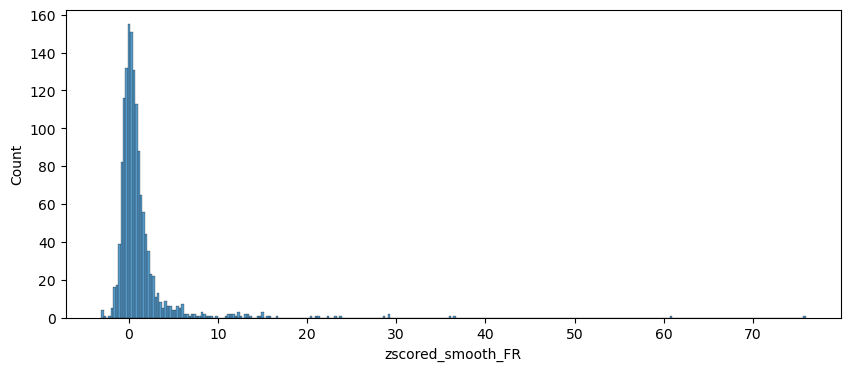

In [47]:
zscored_spikes_col = []

for row in range(len(df_encoding)):

    base_mean = np.nanmean(df_baseline['trial_smooth_spikes'].iloc[row])
    base_sd = np.nanstd(df_baseline['trial_smooth_spikes'].iloc[row])
    
    if base_sd > 0:
        zscore_smooth_spikes = (df_encoding['trial_smooth_spikes'].iloc[row] - base_mean) / base_sd
    else: # trials where there is only 1 spike during baseline will have sd=0
        zscore_smooth_spikes = df_encoding['trial_smooth_spikes'].iloc[row]
    zscored_spikes_col.append(zscore_smooth_spikes)

df_encoding['zscored_smooth_spikes'] = zscored_spikes_col
df_encoding['zscored_smooth_FR'] = df_encoding['zscored_smooth_spikes'].apply(lambda x: np.mean(x))

df_encoding.to_csv('encoding_trials_zscored.csv', index=False)
print(f'{len(df_encoding)} trials')

plt.figure(figsize=(10,4))
sns.histplot(df_encoding['zscored_smooth_FR'])
plt.show()

### plot smooth FRs of individual neurons from different regions, across sessions

Significant proportions of cells were event selective in the vmPFC (10/175, p =  0.005, permutation test) and preSMA (20/299,  p <  0.001) but not in the amygdala (15/479, p =  0.081), ACC (7/236, p =  0.224), and hippocampus (8/261, p = 0.199;  Fig. 7a,b show examples).

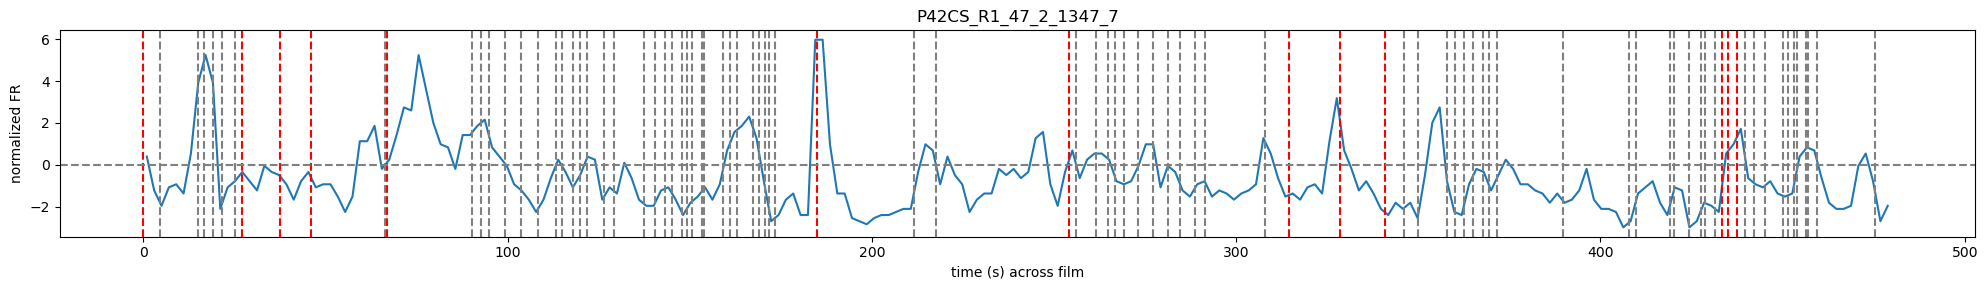

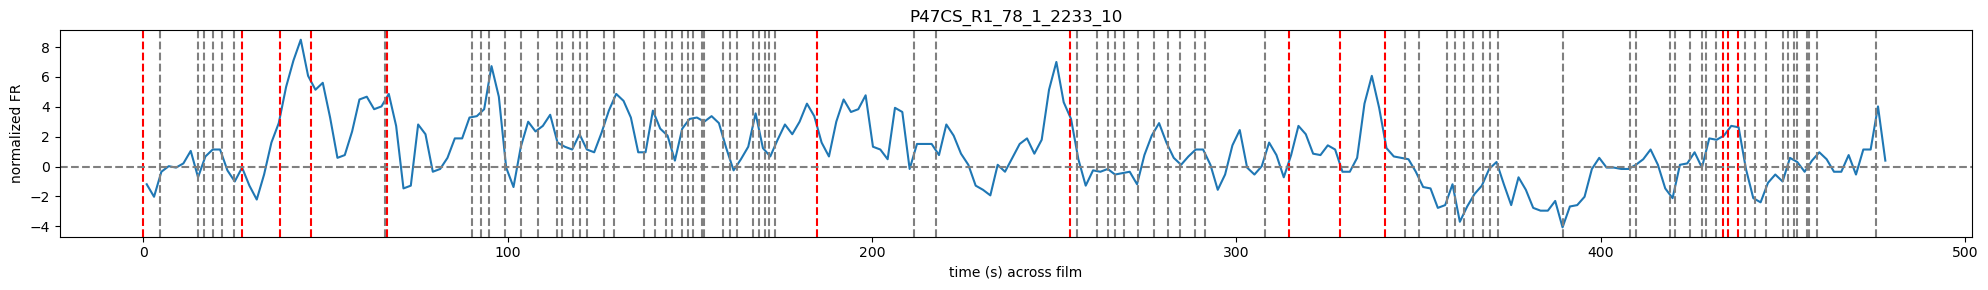

In [8]:
for neuron in ['P42CS_R1_47_2_1347_7', 'P47CS_R1_78_1_2233_10']:

    neuron_df = df_encoding[df_encoding['neuron'] == neuron]

    # Get the length of the first spike array
    num_bins = len(neuron_df['zscored_smooth_spikes'].iloc[0])
    x_time_points = np.linspace(1, np.max(neuron_df['RT']), num_bins)

    plt.figure(figsize=(20, 3))
    plt.plot(x_time_points, neuron_df['zscored_smooth_spikes'].iloc[0], label=neuron)

    for cut, color in zip(cuts_df['shot_start_t'], cuts_df['cut_colors']):
        plt.axvline(x=cut, color=color, linestyle='--')

    plt.xlabel('time (s) across film')
    plt.ylabel('normalized FR')
    plt.title(neuron)
    plt.axhline(0, color='grey', linestyle='--')
    plt.tight_layout()
    plt.show()


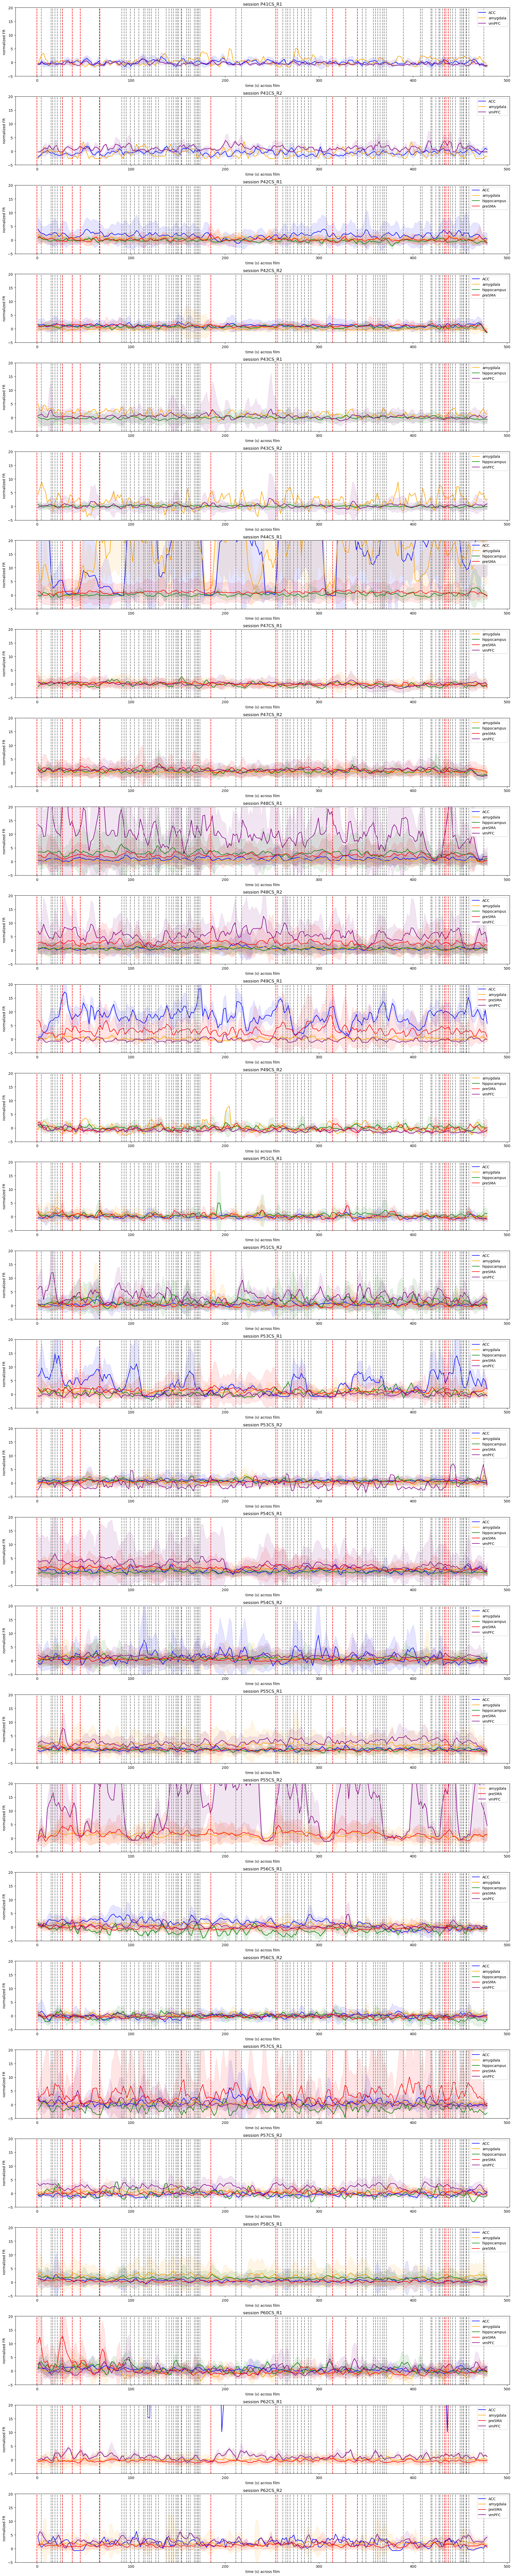

In [66]:
sess_num = 0  # specify how many sessions to plot

# to convert x-axis from bins to time
num_bins = len(df_encoding['zscored_smooth_spikes'].iloc[0])
x_time_points = np.linspace(1, np.max(df_encoding['RT']), num_bins)

# plot settings
fig, axs = plt.subplots(29, 1, figsize=(20, 100))
color_map = {'ACC': 'blue', 'amygdala': 'orange', 'hippocampus': 'green', 'preSMA': 'red', 'vmPFC': 'purple'}

for session, session_df in df_encoding.groupby('sess'):

    for region, region_df in session_df.groupby('region'):
        
        # convert groupby obj to 2d arr
        zscored_smooth_spikes_arr = np.array(region_df['zscored_smooth_spikes'].tolist())

        # get the avg and std smoothed FR across neurons of a region  
        smooth_FR_region_avg = np.nanmean(zscored_smooth_spikes_arr, axis=0)
        smooth_FR_region_sd = np.nanstd(zscored_smooth_spikes_arr, axis=0) 

        # plot
        axs[sess_num].plot(x_time_points, smooth_FR_region_avg, label=region, color=color_map.get(region))
        axs[sess_num].fill_between(x_time_points,
                                   smooth_FR_region_avg - smooth_FR_region_sd, smooth_FR_region_avg + smooth_FR_region_sd,
                                   alpha=0.1, color=color_map.get(region))
        
    
    # make vertical lines at each scene cut
    for cut, color in zip(cuts_df['shot_start_t'], cuts_df['cut_colors']):
        axs[sess_num].axvline(x=cut, color=color, linestyle='--')

    axs[sess_num].set_title(f'session {session}')
    axs[sess_num].set_xlabel('time (s) across film')
    axs[sess_num].set_ylabel('normalized FR')
    axs[sess_num].set_ylim(-5, 20)
    axs[sess_num].legend(loc='upper right')
    
    sess_num += 1


plt.tight_layout()  
plt.show()


### trial-avged FRs by correctness

In [30]:
# print(df_recognition.groupby(['region', 'response_correct']).size())

# trial_avg_fr = df_recognition.groupby(['region', 'neuron', 'response_correct'])['FR'].mean().reset_index()
# plt.figure(figsize=(12, 6))
# sns.violinplot(data=trial_avg_fr, x='region', y='FR', hue='response_correct')
# plt.title('Trial-avged neuron FR')
# plt.show()


In [ ]:
# sess_num = 0  # specify how many sessions to plot

# fig, axs = plt.subplots(29, 1, figsize=(20, 100))

# for session, session_df in df_encoding.groupby('sess'):

#     for region, region_df in session_df.groupby('region'):

#         if True: #region == 'vmPFC':

#             # convert x-axis from bins to time
#             num_bins = len(df_encoding['zscored_smooth_spikes'].iloc[0])
#             x_time_points = np.linspace(1, np.max(neuron_df['RT']), num_bins)

#             neuron_groups = list(region_df.groupby('neuron'))

#             # pick random neuron from each region
#             rand_neuron_id = np.random.randint(len(neuron_groups))
#             neuron, neuron_df = neuron_groups[rand_neuron_id]

#             axs[sess_num].plot(x_time_points, neuron_df['zscored_smooth_spikes'].iloc[0], label=region)

#     # make vertical lines at each scene cut
#     for cut, color in zip(cuts_df['shot_start_t'], cuts_df['cut_colors']):
#         axs[sess_num].axvline(x=cut, color=color, linestyle='--')

#     axs[sess_num].set_title(f'session {session}')
#     axs[sess_num].set_xlabel('time (s) across film')
#     axs[sess_num].set_ylabel('normalized FR')
#     axs[sess_num].set_ylim(-5, 20)
#     axs[sess_num].legend(loc='upper right')
    
#     sess_num += 1

# plt.tight_layout()  
# plt.show()
